In [1]:
%matplotlib inline
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix
from fonction import kpi, plot_auc, mat_conf2, Mise_enforme
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

couleur = Mise_enforme()
pal = [couleur.lkp_green,couleur.lkp_blue,couleur.lkp_magenta,couleur.lkp_comp_blue,couleur.lkp_grey]


save_X_train = "data/X_train.pkl"
save_X_test = "data/X_test.pkl"
save_target_train = "data/y_train.pkl"
save_target_test = "data/y_test.pkl"

with open(save_X_train, "rb") as f:
    X_train = pk.load(f)
with open(save_X_test, "rb") as f:
    X_test = pk.load(f)
with open(save_target_train, "rb") as f:
    y_train = pk.load(f)
with open(save_target_test, "rb") as f:
    y_test = pk.load(f)


## Modélisation : recherche du meilleur modèle logistique

La régression logistique est un modèle statistique paramétrique (dépend d'une loi de probabilité) qui permet d'analyser les relations entre un ensemble de variables expliquatives $X_{i}$ (disrêtes ou continues) et une variable cible y définie par :

Pour la construction du modèle logistique, il faut spécifier l'inverse du paramètre de régularisation `C`. 

Dans cette section, nous commençons par crer le classifieur `LogisticRegression`, puis nous créons un transformeur afin de choisir les variables ayant le plus d'impact sur la variable cible.
Par la suite, nous créons un pipeline afin de paralélliser ces différentes transformation (sélection et apprentissage). Pour avoir le meilleur estimateur logistique sur les variables les plus impactantes, nous créons un `GridSearch` pour faire varier les paramètres du modèle et le nombre de variable pertinence à sélectionner.

- le paramètre `penalty` définie la stratégie de pénalisation utilisée pour métriser l'amplitude des coefficients des variables utilisées pour la modélisation. Dans notre cas de figure on utilisera une pénalité `l2` et une combinaison des pénalités `l1` et `l2` (`elasticnet`).

- le paramètre `solver` définie l'algorithme utilisée pour l'optimisation. Les algorithmes choisis sont fonctions de la taille du jeux de données. Pour notre problématique, et au vu de la taille de la base, nous choisisons l'algorithme `saga`.

- le paramètre `C` défini l'inverse du paramètre de régulation.

- le paramètre `k` défini les k-premières variables ayant le plus de poids.

In [2]:
cv5 = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=1759)

clf = LogisticRegression(random_state=1759,
                         solver='saga',
                         penalty="elasticnet",
                         class_weight='balanced',
                         l1_ratio = 0.1,
                         max_iter=10000)

selection_variable = SelectKBest(score_func=f_regression,
                                 k=5)

pipeline_logistic = Pipeline(steps=[("selection", selection_variable),
                                    ("modele", clf)])

pipeline_logistic.fit(X_train,y_train)
params = {"selection__k" : [5,10,20,30,"all"],
          "modele__solver": ["sag","saga"],
          "modele__l1_ratio" : np.arange(0,1,0.01),
          "modele__C" : np.logspace(-6,8,15)}


grid = GridSearchCV(estimator=pipeline_logistic,
                    param_grid=params,
                    scoring="accuracy",
                    n_jobs = -1, 
                    verbose = 10,
                    cv=5)

grid.fit(X_train,y_train)
data_params_model = pd.DataFrame(grid.cv_results_)[["params",
                                                    "mean_test_score",
                                                    "std_test_score"]]
                                                  
clf_rl = grid.best_estimator_


Fitting 5 folds for each of 15000 candidates, totalling 75000 fits


## Sauvegarde du modèle

Le meilleur estimateur logistique obtenue par validation croisée est sauvegardée pour être réutilisé plutard lors de la comparaison avec d'autres familles d'estimateur. Pour ce dernier, nous avons les paramètres suivants :

In [ ]:
save_model = "modele/clf_rl.pkl"

with open(save_model,"wb")as f:
    pk.dump(clf_rl,f)

grid.best_params_

{'modele__C': 0.3593813663804626,
 'modele__l1_ratio': 0.6000000000000001,
 'selection__k': 'all'}

### Prédiction

Nous faisons ensuite quelques prédictions sur les échantillons splités : X_train et X_test.

In [ ]:
y_pred_test = clf_rl.predict(X_test)
probs_test = clf_rl.predict_proba(X_test)

y_pred_train = clf_rl.predict(X_train)
probs_train = clf_rl.predict_proba(X_train)


### Evaluation du modèle 
Le taux de bonne prédictions (`accuracy`) d'un modèle est une métrique souvent utilisée en classification et correspond au nombre d'éléements bien classés sur le nombre total d'obsevations. Pour notre problématique, nous obtenons le score ci-dessous : 

In [ ]:
kpi(clf_rl,X_train,X_test,y_train,y_test,5)

Moyenne du score obtenus
random forest : accuracy sur train 0.79 +/- 0.01
random forest : accuracy sur test  0.78 +/- 0.03


# Matrice de confusion

Cet indicateur permet de calculer une série de KPI dont l'interpretation est fonction du problème étudié. Dans le cadre de ce challenge, nous nous limiterons à calculer l'AUC de chaque modèle.

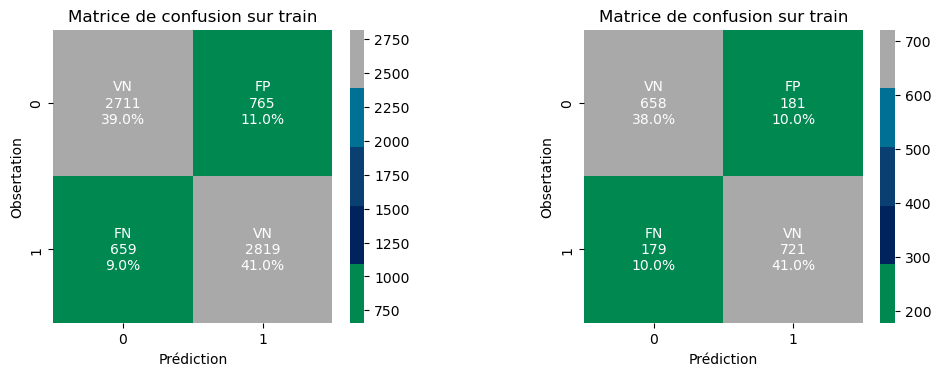

In [ ]:
#mat_conf(clf_rl,X_train,X_test,y_train,y_test)

mat_conf2(y_train, y_pred_train,y_test, y_pred_test,pal)


# Calcul de l'AUC sur les données X_train et X_test

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets passagers au hasard, un passager transporté dans une autre dimenssion et un non-transporté, la valeur du marqueur soit plus élevée pour celui transporté que pour le non-transporté. Par conséquent, une AUC de 0,5 (50%) indique que le marqueur est non-informatif. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1. Plus nous sommes proches de 1, meilleur est le modèle. 

La valeur de l'AUC est de : 0.8820527980910421
La valeur de l'AUC est de : 0.8775936961991788


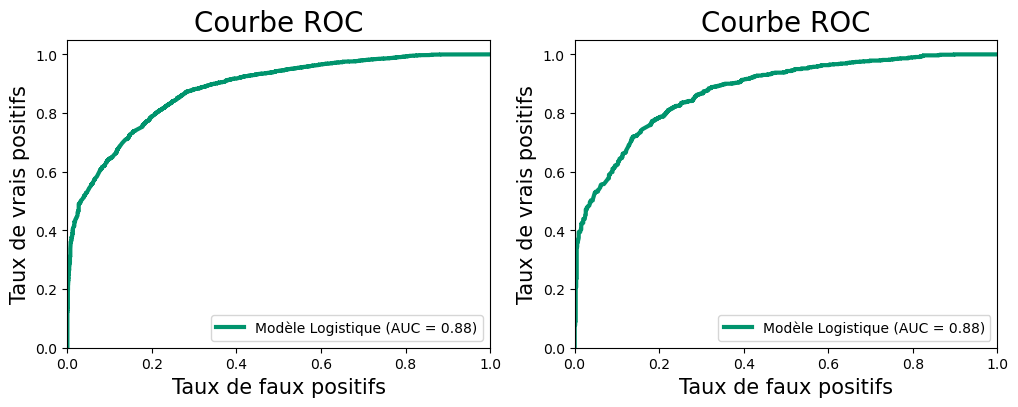

In [ ]:
fig = plt.figure(figsize=(12,4))
plot_auc(y_train, probs_train,1,fig)

plot_auc(y_test, probs_test,2,fig)
#La valeur de l'AUC est de : 0.8820527980910421
#La valeur de l'AUC est de : 0.8775936961991788